1. Processes individual raw weather station files (adapted from Vasu's code). 
2. Merges them into a unified dataset. 
3. Runs PCA to retain 95% of explained variance and reports dropped features.

In [61]:
import os
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from constants import DROP_COLUMNS, CITY_NAMES, DATE_RANGE, NUMERICAL_COLUMNS, COLUMN_ORDER

# 1. Process raw NOAA files and split per station
def process_data(file_basename):
    df = pd.read_csv(f"data/raw/{file_basename}.csv")
    df = df.drop(columns=DROP_COLUMNS, errors="ignore")
    df["DATE"] = pd.to_datetime(df["DATE"])

    groups = df.groupby("NAME")

    for station_name, station_data in groups:
        city_found = False
        for city in CITY_NAMES:
            if city in station_name:
                station_name = city
                station_data["NAME"] = city
                CITY_NAMES.remove(city)
                city_found = True
                break

        if not city_found:
            print(f"Skipping unknown station: {station_name}")
            continue

        station_data.set_index("DATE", inplace=True)
        station_data = station_data.sort_index().reindex(DATE_RANGE)
        station_data.index.name = "DATE"  # Ensure DATE is saved correctly

        # Restore static columns
        station_data["NAME"] = station_data["NAME"].fillna(station_name)
        station_data["LATITUDE"] = station_data["LATITUDE"].fillna(station_data["LATITUDE"].mode()[0])
        station_data["LONGITUDE"] = station_data["LONGITUDE"].fillna(station_data["LONGITUDE"].mode()[0])
        station_data["ELEVATION"] = station_data["ELEVATION"].fillna(station_data["ELEVATION"].mode()[0])

        for col in NUMERICAL_COLUMNS:
            if col not in station_data.columns:
                station_data[col] = np.nan
            station_data[col] = station_data[col].fillna(station_data[col].mean())

        station_data = station_data[COLUMN_ORDER]

        os.makedirs("data/processed", exist_ok=True)
        station_data.reset_index().to_csv(f"data/processed/{station_name}.csv", index=False)
        print(f"Processed: {station_name}.csv")

# Run all acronym files
files = ["CMCTB", "RGEDM", "SGASS", "FSALH", "MHWTM", "CHIMM", "SBGAE"]
for f in files:
    process_data(f)

Skipping unknown station: BUFFALO NIAGARA INTERNATIONAL AIRPOR, NY US
Skipping unknown station: CHICAGO MIDWAY AIRPORT 3 SW, IL US
Skipping unknown station: CLEVELAND HOPKINS INTERNATIONAL AIRPORT, OH US
Skipping unknown station: MILWAUKEE MITCHELL AIRPORT, WI US
Skipping unknown station: TOLEDO EXPRESS AIRPORT, OH US
Skipping unknown station: DETROIT METRO AIRPORT, MI US
Skipping unknown station: ERIE INTERNATIONAL AIRPORT, PA US
Skipping unknown station: FREDERICK DOUGLASS GREATER ROCHESTER INTERNATIONAL AIRPORT, NY US
Skipping unknown station: GREEN BAY A S INTERNATIONAL AIRPORT, WI US
Skipping unknown station: MARQUETTE WEATHER FORECAST OFFICE, MI US
Skipping unknown station: APPLETON, WI US
Skipping unknown station: GRAND RAPIDS GERALD R FORD INTERNATIONAL AIRPORT, MI US
Skipping unknown station: SAULT STE MARIE SANDERSON FIELD, MI US
Skipping unknown station: SOUTH BEND AIRPORT, IN US
Skipping unknown station: SYRACUSE HANCOCK INTERNATIONAL AIRPORT, NY US
Skipping unknown station

In [62]:
# 2. Merge all processed station files
def merge_processed_data():
    dfs = []
    for f in os.listdir("data/processed"):
        if f.endswith(".csv"):
            try:
                df = pd.read_csv(f"data/processed/{f}")
                if "DATE" not in df.columns:
                    print(f"Skipping {f} — no DATE column.")
                    continue
                df["DATE"] = pd.to_datetime(df["DATE"])
                df["STATION"] = f.replace(".csv", "")
                df.set_index("DATE", inplace=True)
                dfs.append(df)
            except Exception as e:
                print(f"Error reading {f}: {e}")
    if not dfs:
        raise ValueError("No valid processed CSV files found.")
    merged = pd.concat(dfs)
    merged.sort_index(inplace=True)
    return merged

# Merge and store
merged_df = merge_processed_data()
os.makedirs("data", exist_ok=True)

(383565, 34)
Selected 11 components to retain 95.0% variance
Index(['ACSH', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'TSUN',
       'WDF5', 'WDFG'],
      dtype='object')


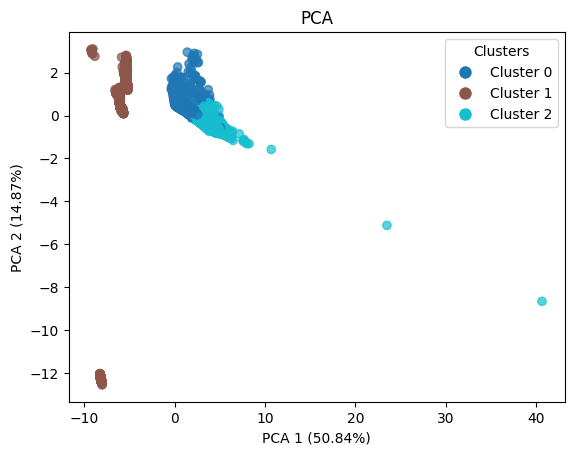

<Figure size 1200x600 with 0 Axes>

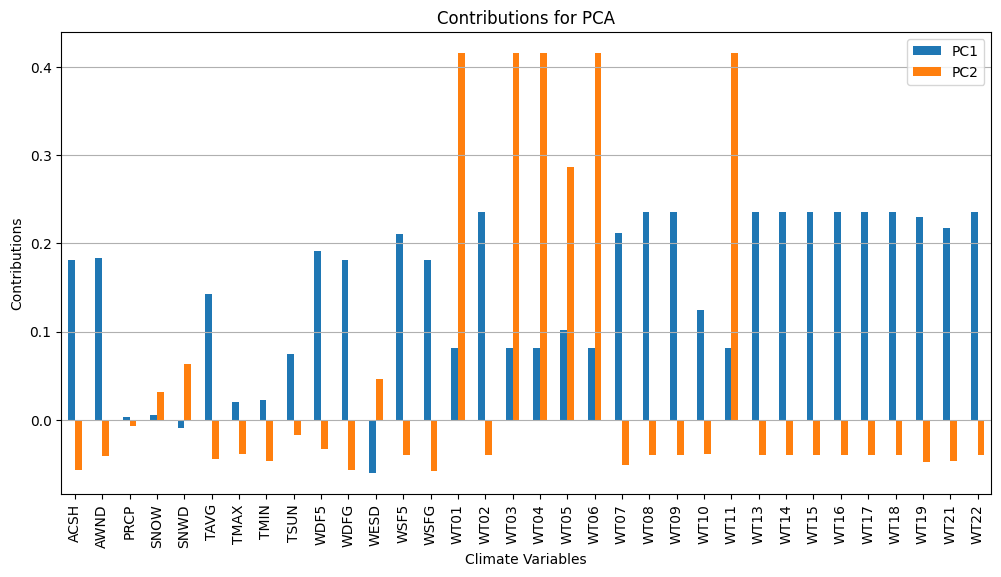

Contributors to PC1:
 WT14    0.235128
WT02    0.235128
WT08    0.235128
WT18    0.235128
WT17    0.235128
Name: PC1, dtype: float64

Contributors to PC2:
 WT01    0.41612
WT04    0.41612
WT11    0.41612
WT03    0.41612
WT06    0.41612
Name: PC2, dtype: float64
Saved PCA-reduced dataset with original column names to data/merged_pca.csv


In [65]:
# 3. PCA reduction (dynamic threshold)
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.cluster import KMeans

def run_pca(df, variance_threshold=0.95):
    station_meta = ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION"]
    meta_df = df[station_meta]
    features = df.drop(columns=station_meta, errors="ignore")
    features = features.dropna(axis=1, how="all")
    features = features.fillna(0.0)
    #print(features.columns)

    scaler = StandardScaler()
    X = scaler.fit_transform(features)
    print(X.shape)

    full_pca = PCA()
    full_pca.fit(X)
    

    cumulative = full_pca.explained_variance_ratio_.cumsum()
    n_components = np.argmax(cumulative >= variance_threshold) + 1
    print(f"Selected {n_components} components to retain {variance_threshold*100:.1f}% variance")

    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)

    pca_feature_names = features.columns[:n_components]
    pca_df = pd.DataFrame(X_reduced, index=features.index, columns=pca_feature_names)
    final_df = pd.concat([meta_df, pca_df], axis=1)
    #print(final_df.head(3))
    print(pca_df.columns)
    
    kmeans = KMeans(n_clusters=3, random_state=42) 
    cluster_labels = kmeans.fit_predict(pca_df)
    pca_df['cluster'] = cluster_labels
    fig, ax = plt.subplots() 
    plot = ax.scatter(pca_df.iloc[:, 0], pca_df.iloc[:, 1], c=pca_df['cluster'],
    cmap='tab10',
    alpha=0.7)
    ax.set_xlabel(f'PCA 1 ({full_variance[0] * 100:.2f}%)')
    ax.set_ylabel(f'PCA 2 ({full_variance[1] * 100:.2f}%)')
    ax.set_title(f"PCA")
    
    legend_labels = [f'Cluster {i}' for i in sorted(pca_df['cluster'].unique())]
    handles = [Line2D([], [], color='w', marker='o', label=label,
                         markerfacecolor=plot.cmap(plot.norm(i)), markersize=10)
           for i, label in enumerate(legend_labels)]
    ax.legend(handles=handles, title="Clusters")

    
    plt.show()
    
    contributions = pd.DataFrame(
    full_pca.components_.T,
    columns=[f'PC{i+1}' for i in range(full_pca.n_components_)],
    index=features.columns
    )
    pc1 = contributions['PC1'].abs().sort_values(ascending=False).head(5)
    pc2 = contributions['PC2'].abs().sort_values(ascending=False).head(5)
    plt.figure(figsize=(12, 6))
    contributions[['PC1', 'PC2']].plot(kind='bar', figsize=(12, 6))
    plt.title("Contributions for PCA")
    plt.ylabel("Contributions")
    plt.xlabel("Climate Variables")
    plt.grid(True, axis='y')
    plt.show()


    print("Contributors to PC1:\n", pc1)
    print("\nContributors to PC2:\n", pc2)
    
    return final_df, n_components, pca, full_pca.explained_variance_ratio_

# Run PCA
final_df, n_components_used, pca_model, full_variance = run_pca(merged_df)
final_df.to_csv("data/merged_pca.csv")
print("Saved PCA-reduced dataset with original column names to data/merged_pca.csv")

In [4]:
# # Load the PCA-transformed dataset and print explained variance by component

# import pandas as pd
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import StandardScaler

# # Load full merged dataset (before PCA)
# merged_df = pd.read_csv("data/merged_full.csv", parse_dates=["DATE"])
# merged_df.set_index("DATE", inplace=True)

# # Extract only numerical features
# station_meta = ["STATION", "NAME", "LATITUDE", "LONGITUDE", "ELEVATION"]
# features = merged_df.drop(columns=station_meta, errors="ignore")
# features = features.dropna(axis=1, how="all")
# features = features.fillna(0.0)

# # Standardize features
# scaler = StandardScaler()
# X = scaler.fit_transform(features)

# # Fit PCA on all components
# pca = PCA()
# X_pca = pca.fit_transform(X)

# # Store explained variance
# explained_variance = pd.DataFrame({
#     "Component": [f"PC{i+1}" for i in range(len(pca.explained_variance_ratio_))],
#     "ExplainedVariance": pca.explained_variance_ratio_,
#     "CumulativeVariance": pca.explained_variance_ratio_.cumsum()
# })

# # Save and print summary
# explained_variance.to_csv("data/pca_variance_full_components.csv", index=False)
# print("Saved explained variance for all PCA components to data/pca_variance_full_components.csv")
# print(explained_variance.head(40))